In [2]:
import csv
import random
import pandas as pd
from tqdm import tqdm
from itertools import islice
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
from datasets import load_dataset

SEED = 1337
random.seed(SEED)

INFO 03-16 01:30:40 __init__.py:190] Automatically detected platform cuda.


In [3]:
dataset = load_dataset("liamdugan/raid", "raid")["train"]
dataset

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

Dataset({
    features: ['id', 'adv_source_id', 'source_id', 'model', 'decoding', 'repetition_penalty', 'attack', 'domain', 'title', 'prompt', 'generation'],
    num_rows: 5615820
})

In [4]:
dataset = dataset.filter(lambda x: x["model"] == "human")
df = dataset.to_pandas()
df.head()

,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,generation
0,e5e058ce-be2b-459d-af36-32532aaba5ff,e5e058ce-be2b-459d-af36-32532aaba5ff,e5e058ce-be2b-459d-af36-32532aaba5ff,human,None,None,none,abstracts,FUTURE-AI: Guiding Principles and Consensus Re...,None,The recent advancements in artificial intellig...
1,f95b107b-d176-4af5-90f7-4d0bb20caf93,f95b107b-d176-4af5-90f7-4d0bb20caf93,f95b107b-d176-4af5-90f7-4d0bb20caf93,human,None,None,none,abstracts,EdgeFlow: Achieving Practical Interactive Segm...,None,High-quality training data play a key role in ...
2,856d8972-9e3d-4544-babc-0fe16f21e04d,856d8972-9e3d-4544-babc-0fe16f21e04d,856d8972-9e3d-4544-babc-0fe16f21e04d,human,None,None,none,abstracts,Semi-supervised Contrastive Learning for Label...,None,The success of deep learning methods in medica...
3,fbc8a5ea-90fa-47b8-8fa7-73dd954f1524,fbc8a5ea-90fa-47b8-8fa7-73dd954f1524,fbc8a5ea-90fa-47b8-8fa7-73dd954f1524,human,None,None,none,abstracts,Combo Loss: Handling Input and Output Imbalanc...,None,Simultaneous segmentation of multiple organs f...
4,72c41b8d-0069-4886-b734-a4000ffca286,72c41b8d-0069-4886-b734-a4000ffca286,72c41b8d-0069-4886-b734-a4000ffca286,human,None,None,none,abstracts,Attention-Based 3D Seismic Fault Segmentation ...,None,Detection faults in seismic data is a crucial ...


In [5]:
df.isna().sum()

id                         0
adv_source_id              0
source_id                  0
model                      0
decoding              160452
repetition_penalty    160452
attack                     0
domain                     0
title                      0
prompt                160452
generation                 0
dtype: int64

In [6]:
df["title_length"] = df["title"].str.len()
df["generation_length"] = df["generation"].str.len()

In [7]:
df = df[(df["title_length"] >= 10) & (df["generation_length"] >= 50)]

In [8]:
df.duplicated(subset="generation").sum()

np.int64(12928)

In [9]:
df.drop_duplicates(subset=["generation"], inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
len(df)

138244

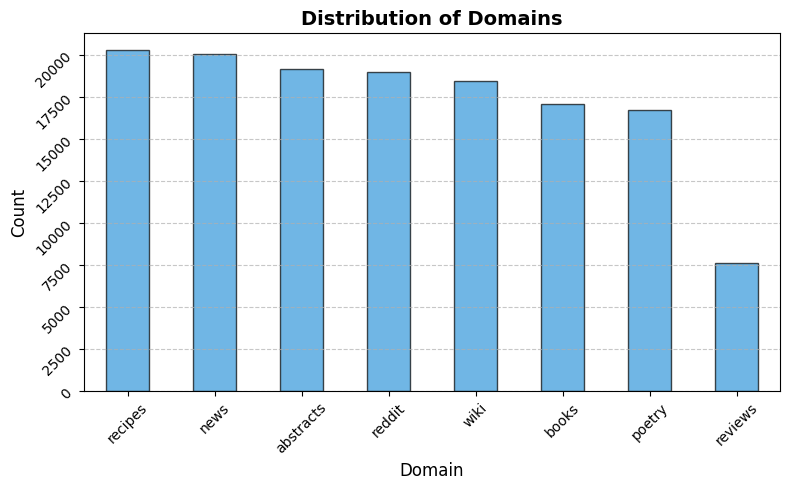

In [11]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

# Domain count bar plot
df["domain"].value_counts().plot(kind="bar", ax=ax, color='#3498db', edgecolor='black', alpha=0.7)

# Customize plot
ax.set_title('Distribution of Domains', fontsize=14, fontweight='bold')
ax.set_xlabel('Domain', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10, rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [12]:
def batchify(iterable, batch_size):
    """Splits an iterable into smaller batches."""
    iterable = iter(iterable)
    while batch := list(islice(iterable, batch_size)):
        yield batch

def save_to_csv(path, prompts, responses, temperature, top_p, top_k):
    """Saves prompts, responses and sampling parameters to a CSV file."""
    with open(path, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for prompt, response in zip(prompts, responses):
            writer.writerow([prompt, response, temperature, top_p, top_k])

def generate_responses(model, prompts, sampling_params):
    """Generate a batch of outputs using vLLM with customizable sampling parameters."""
    outputs = model.chat(prompts, sampling_params=sampling_params, use_tqdm=False)
    
    return [sample.outputs[0].text.replace('"', '') for sample in outputs]

In [13]:
BASE_PROMPT = [{"role": "system", "content": "You are a helpful assistant specializing in writing texts across various domains, including abstracts and news articles, based on provided titles. Based on provided domain and title generate a text of appropriate length related to the domain and title. MAKE SURE TO REPLAY ONLY WITH THE GENERATED TEXT."},
                {"role": "user", "content": "Domain: \n {domain} \n Title: {title}"},
                {"role": "assistant", "content": "Generated text: \n"}]

In [14]:
prompts = [
    [
        BASE_PROMPT[0],  # The system message
        {"role": "user", "content": BASE_PROMPT[1]["content"].format(domain=domain, title=title)},  # Formatted user message
        BASE_PROMPT[2]  # The assistant message
    ]
    for domain, title in df[["domain", "title"]].values
]

In [15]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

In [16]:
lens = []
batch_size = 128
for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
    tokens = tokenizer.apply_chat_template(prompts_batch)
    lens.extend([len(token) for token in tokens])

1081it [00:30, 35.21it/s]                          


In [17]:
too_large = [i for i, l in enumerate(lens) if l > 16_384]
too_large

[]

In [17]:
df.drop(["id", "adv_source_id", "source_id", "model", "decoding", "repetition_penalty", "attack", "domain", "title", "prompt"], axis=1, inplace=True)
df.to_csv("../../data/data_human/raid.csv", index=False)

In [18]:
from nltk.tokenize import word_tokenize, sent_tokenize
df['word_count'] = df['generation'].apply(lambda x: len(word_tokenize(x)))
df['sentence_count'] = df['generation'].apply(lambda x: len(sent_tokenize(x)))

In [19]:
import numpy as np
import matplotlib.ticker as ticker

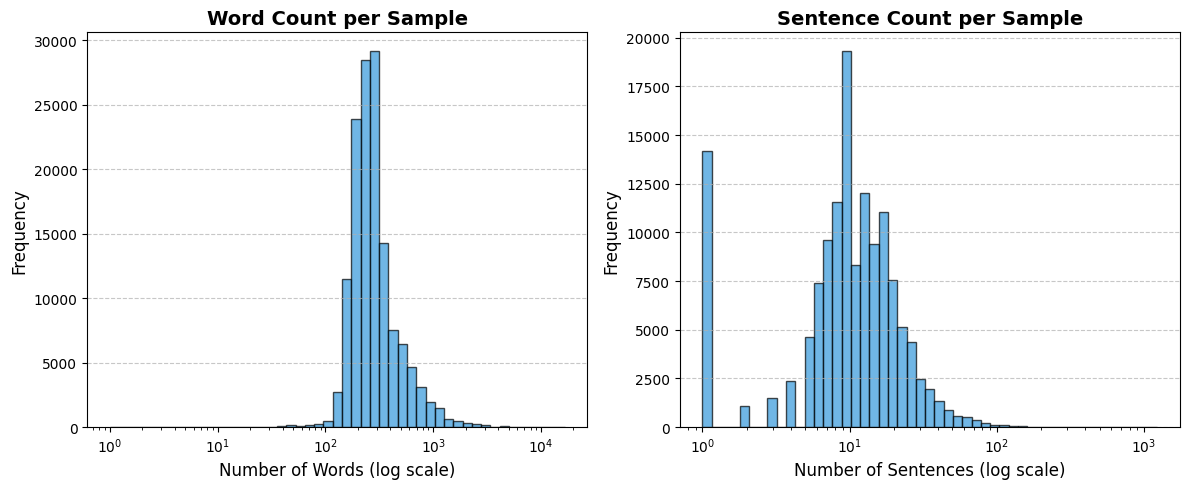

In [20]:
import matplotlib.pyplot as plt
word_bins = np.logspace(np.log10(1), np.log10(df['word_count'].max()), 50)
sentence_bins = np.logspace(np.log10(1), np.log10(df['sentence_count'].max()), 50)

# Plot histograms using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Word count histogram
axes[0].hist(df['word_count'], bins=word_bins, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_xscale('log')  # Logarithmic scale for x-axis
axes[0].set_title('Word Count per Sample', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Words (log scale)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].tick_params(axis='both', which='minor', labelsize=8)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Sentence count histogram
axes[1].hist(df['sentence_count'], bins=sentence_bins, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].set_xscale('log')  # Logarithmic scale for x-axis
axes[1].set_title('Sentence Count per Sample', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Sentences (log scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].tick_params(axis='both', which='minor', labelsize=8)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [22]:
sampling_params = [
    SamplingParams(temperature=0.0, top_p=1.0, top_k=-1, max_tokens=30_000, seed=SEED),  # Pure Greedy (fully deterministic)
    SamplingParams(temperature=0.2, top_p=1.0, top_k=-1, max_tokens=30_000, seed=SEED),  # Highly Deterministic
    SamplingParams(temperature=0.5, top_p=0.95, top_k=100, max_tokens=30_000, seed=SEED), # Mildly Deterministic but Flexible
    SamplingParams(temperature=0.7, top_p=0.9, top_k=50, max_tokens=30_000, seed=SEED),  # Balanced and Natural
    SamplingParams(temperature=0.9, top_p=0.8, top_k=40, max_tokens=30_000, seed=SEED),  # Slightly More Diverse but Coherent
    SamplingParams(temperature=1.0, top_p=0.95, top_k=30, max_tokens=30_000, seed=SEED), # Default Creative Mode
    SamplingParams(temperature=1.2, top_p=0.7, top_k=20, max_tokens=30_000, seed=SEED),  # Highly Creative
]

In [23]:
llms = ["meta-llama/Llama-3.2-1B-Instruct"]
batch_size = 8
base_path = "../../data/data_ai/raid/raid_"

In [ ]:
for llm in llms:
    model = LLM(model=llm, dtype="half", max_model_len = 10_000)
    csv_path = f"{base_path}{llm.split('/')[-1]}.csv"


    # init csv file
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["prompt", "response", "temperature", "top_p", "top_k"])

    cnt = 0
    for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
        params = random.choice(sampling_params)
        responses = generate_responses(model, prompts_batch, params)
        save_to_csv(csv_path, prompts_batch, responses, params.temperature, params.top_p, params.top_k)
        cnt += 1
        if cnt > 2:
            break

  0%|          | 2/1253 [05:04<52:56:25, 152.35s/it]


In [50]:
df = pd.read_csv("../../data/data_ai/raid/raid_Llama-3.2-1B-Instruct.csv")
df.head()

,prompt,response,temperature,top_p,top_k
0,"[{'role': 'system', 'content': 'You are a help...",In the rapidly evolving field of artificial in...,1.2,0.7,20
1,"[{'role': 'system', 'content': 'You are a help...",EdgeFlow: A Novel Approach to Practical Intera...,1.2,0.7,20
2,"[{'role': 'system', 'content': 'You are a help...",Semi-supervised contrastive learning has emerg...,1.2,0.7,20
3,"[{'role': 'system', 'content': 'You are a help...",Combining Loss Functions for Improved Multi-Or...,1.2,0.7,20
4,"[{'role': 'system', 'content': 'You are a help...",Attention-Based 3D Seismic Fault Segmentation ...,1.2,0.7,20
